In [2]:
import requests
import pandas as pd
from typing import Dict, List
from dataclasses import dataclass
from datetime import datetime
from web3 import Web3, HTTPProvider

@dataclass
class TokenInfo:
    symbol: str
    address: str

@dataclass
class MarketInfo:
    address: str
    factory_address: str
    llamma: str
    rate: float
    total_debt: float
    n_loans: int
    debt_ceiling: float
    borrowable: float
    pending_fees: float
    collected_fees: float
    collateral_amount: float
    collateral_amount_usd: float
    stablecoin_amount: float
    collateral_token: TokenInfo
    stablecoin_token: TokenInfo



In [18]:
def fetch_curve_markets(chain: str = "ethereum", page: int = 1, per_page: int = 10) -> Dict:
    """
    Fetch crvUSD market data from Curve API
    """
    url = f"https://prices.curve.fi/v1/crvusd/markets/{chain}"
    params = {
        "fetch_on_chain": "false",
        "page": page,
        "per_page": per_page
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()  # Raise exception for bad status codes
    return response.json()

def parse_market_data(market_data: Dict) -> MarketInfo:
    """
    Parse raw market data into MarketInfo object
    """
    
    w3 = Web3()
    
    return MarketInfo(
        address=w3.to_checksum_address(market_data["address"]),
        factory_address=w3.to_checksum_address(market_data["factory_address"]),
        llamma=w3.to_checksum_address(market_data["llamma"]),
        rate=market_data["rate"],
        total_debt=market_data["total_debt"],
        n_loans=market_data["n_loans"],
        debt_ceiling=market_data["debt_ceiling"],
        borrowable=market_data["borrowable"],
        pending_fees=market_data["pending_fees"],
        collected_fees=market_data["collected_fees"],
        collateral_amount=market_data["collateral_amount"],
        collateral_amount_usd=market_data["collateral_amount_usd"],
        stablecoin_amount=market_data["stablecoin_amount"],
        collateral_token=TokenInfo(
            symbol=market_data["collateral_token"]["symbol"],
            address=w3.to_checksum_address(market_data["collateral_token"]["address"])
        ),
        stablecoin_token=TokenInfo(
            symbol=market_data["stablecoin_token"]["symbol"],
            address=w3.to_checksum_address(market_data["stablecoin_token"]["address"])
        )
    )

def get_markets_df() -> pd.DataFrame:
    """
    Fetch market data and return as a pandas DataFrame
    """
    raw_data = fetch_curve_markets()
    markets = [parse_market_data(market) for market in raw_data["data"]]
    
    # Convert to dictionary format suitable for DataFrame
    markets_dict = {
        "address": [],
        "collateral_token": [],
        "rate": [],
        "total_debt": [],
        "n_loans": [],
        "borrowable": [],
        "collateral_amount": [],
        "collateral_amount_usd": [],
        "pending_fees": [],
        "collected_fees": []
    }
    
    for market in markets:
        markets_dict["address"].append(market.address)
        markets_dict["collateral_token"].append(market.collateral_token.symbol)
        markets_dict["rate"].append(market.rate)
        markets_dict["total_debt"].append(market.total_debt)
        markets_dict["n_loans"].append(market.n_loans)
        markets_dict["borrowable"].append(market.borrowable)
        markets_dict["collateral_amount"].append(market.collateral_amount)
        markets_dict["collateral_amount_usd"].append(market.collateral_amount_usd)
        markets_dict["pending_fees"].append(market.pending_fees)
        markets_dict["collected_fees"].append(market.collected_fees)
    
    return pd.DataFrame(markets_dict)

def get_markets_map() -> Dict[str, MarketInfo]:
    """
    Fetch market data and return as a dictionary mapping addresses to MarketInfo objects
    """
    raw_data = fetch_curve_markets()
    markets_map = {}
    
    for market in raw_data["data"]:
        if market["borrowable"] != 0:
            markets_map[market["collateral_token"]["symbol"]] = parse_market_data(market)

    return markets_map


In [19]:
# raw_data = fetch_curve_markets()
# print("Raw data sample:", raw_data["data"][0])

# # Get formatted DataFrame
# df = get_markets_df()
# print("\nFormatted DataFrame:")
# print(df)

# Get markets hashmap
markets = get_markets_map()

In [20]:
markets

{'wstETH': MarketInfo(address='0x100dAa78fC509Db39Ef7D04DE0c1ABD299f4C6CE', factory_address='0xC9332fdCB1C491Dcc683bAe86Fe3cb70360738BC', llamma='0x37417B2238AA52D0DD2D6252d989E728e8f706e4', rate=0.2262671684476214, total_debt=11631213.430479854, n_loans=94, debt_ceiling=None, borrowable=138379515.84313667, pending_fees=10729.273616511444, collected_fees=6229368.062589492, collateral_amount=5983.692238267924, collateral_amount_usd=17768152.401511393, stablecoin_amount=14458.029045727584, collateral_token=TokenInfo(symbol='wstETH', address='0x7f39C581F595B53c5cb19bD0b3f8dA6c935E2Ca0'), stablecoin_token=TokenInfo(symbol='crvUSD', address='0xf939E0A03FB07F59A73314E73794Be0E57ac1b4E')),
 'WBTC': MarketInfo(address='0x4e59541306910aD6dC1daC0AC9dFB29bD9F15c67', factory_address='0xC9332fdCB1C491Dcc683bAe86Fe3cb70360738BC', llamma='0xE0438Eb3703bF871E31Ce639bd351109c88666ea', rate=0.16259679166640262, total_debt=21794166.70994416, n_loans=203, debt_ceiling=None, borrowable=178221031.14214846, 

In [22]:
def fetch_market_snapshots(market_address: str, chain: str = "ethereum", agg: str = "day") -> pd.DataFrame:
    """
    Fetch historical snapshots for a specific crvUSD market
    
    Parameters:
    -----------
    market_address : str
        The market address to fetch snapshots for
    chain : str
        The blockchain network (default: "ethereum")
    agg : str
        Aggregation period - 'day' or 'hour' (default: "day")
    """
    # Ensure we're using checksum address
    w3 = Web3()
    market_address = w3.to_checksum_address(market_address)
    
    url = f"https://prices.curve.fi/v1/crvusd/markets/{chain}/{market_address}/snapshots"
    params = {
        "fetch_on_chain": "false",
        "agg": agg
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()
    
    # Convert to DataFrame
    df = pd.DataFrame(response.json()['data'])
    
    # Process DataFrame
    if not df.empty:
        # Convert timestamp to datetime
        df['dt'] = pd.to_datetime(df['dt'])
        df.set_index('dt', inplace=True)
        
        # Convert scientific notation columns to float
        scientific_columns = ['loan_discount', 'liquidation_discount']
        for col in scientific_columns:
            if col in df.columns:
                df[col] = df[col].astype(float)
        
        # Sort by date ascending
        df.sort_index(inplace=True)
    
    return df


In [94]:
# Get market address from our markets map
market_address = "0xa920de414ea4ab66b97da1bfe9e6eca7d4219635"  # Example address
snapshots_df = fetch_market_snapshots(market_address)

snapshots_df["cr_ratio"] = snapshots_df["total_collateral_usd"] / snapshots_df["total_debt"]
# 30day avg cr_ratio
snapshots_df["cr_ratio_30d"] = snapshots_df["cr_ratio"].rolling(30).mean()
# 7day ema cr_ratio
snapshots_df["cr_ratio_7d"] = snapshots_df["cr_ratio"].rolling(7).mean()
# snapshots_df["cr_ratio_7d"] = snapshots_df["cr_ratio"].ewm(span=7, adjust=False).mean()

snapshots_df["cr_7d/30d"] = snapshots_df["cr_ratio_7d"] / snapshots_df["cr_ratio_30d"]


# Basic info about the data
print("\nDataFrame Info:")
print(snapshots_df.info())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 372 entries, 2023-10-29 to 2024-11-03
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   rate                  372 non-null    float64
 1   minted                372 non-null    float64
 2   redeemed              372 non-null    float64
 3   total_collateral      372 non-null    float64
 4   total_collateral_usd  372 non-null    float64
 5   total_stablecoin      372 non-null    float64
 6   total_debt            372 non-null    float64
 7   n_loans               372 non-null    int64  
 8   amm_price             372 non-null    float64
 9   price_oracle          372 non-null    float64
 10  base_price            372 non-null    float64
 11  min_band              372 non-null    int64  
 12  max_band              372 non-null    int64  
 13  borrowable            372 non-null    float64
 14  loan_discount         372 non-null    

In [24]:
def plot_market_metrics(df: pd.DataFrame, columns: List[str], title: str = "Market Metrics Over Time", figsize: tuple = (12, 6)):
    """
    Plot multiple metrics from market snapshots over time
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing market snapshots data
    columns : List[str]
        List of column names to plot
    title : str
        Plot title (default: "Market Metrics Over Time")
    figsize : tuple
        Figure size in inches (default: (12, 6))
    """
    import matplotlib.pyplot as plt
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Plot each metric
    for column in columns:
        if column in df.columns:
            plt.plot(df.index, df[column], label=column, linewidth=2)
        else:
            print(f"Warning: Column '{column}' not found in DataFrame")
    
    # Customize the plot
    plt.title(title, fontsize=14, pad=15)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    plt.show()


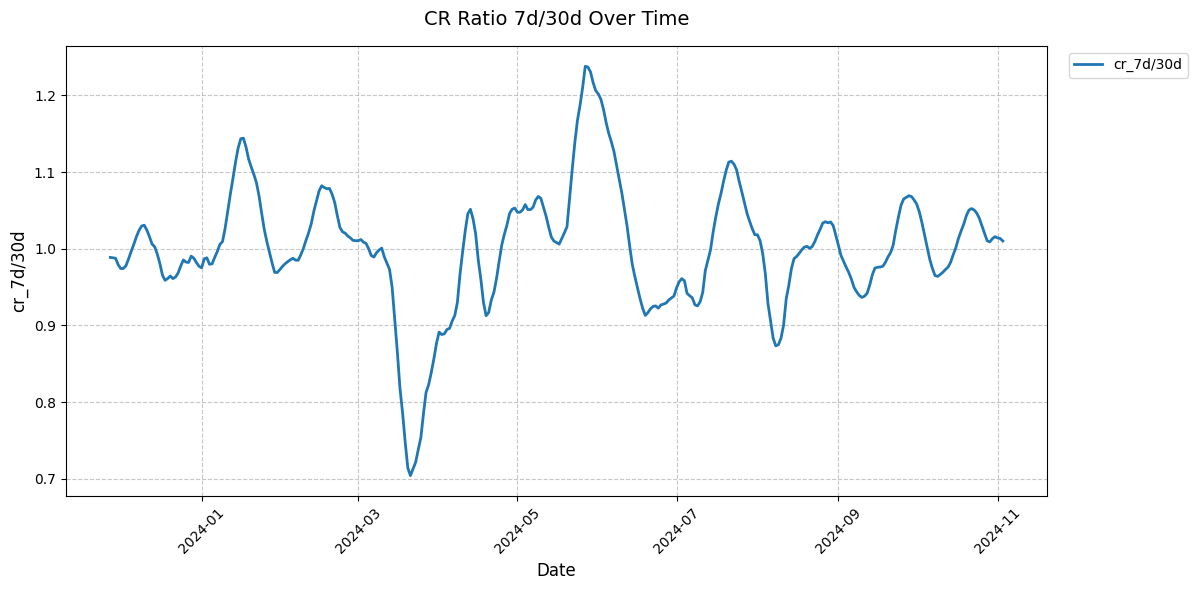

In [95]:
# Plot total debt and collateral amount over time
metrics_to_plot = ['cr_7d/30d']
plot_market_metrics(snapshots_df, metrics_to_plot, "CR Ratio 7d/30d Over Time")


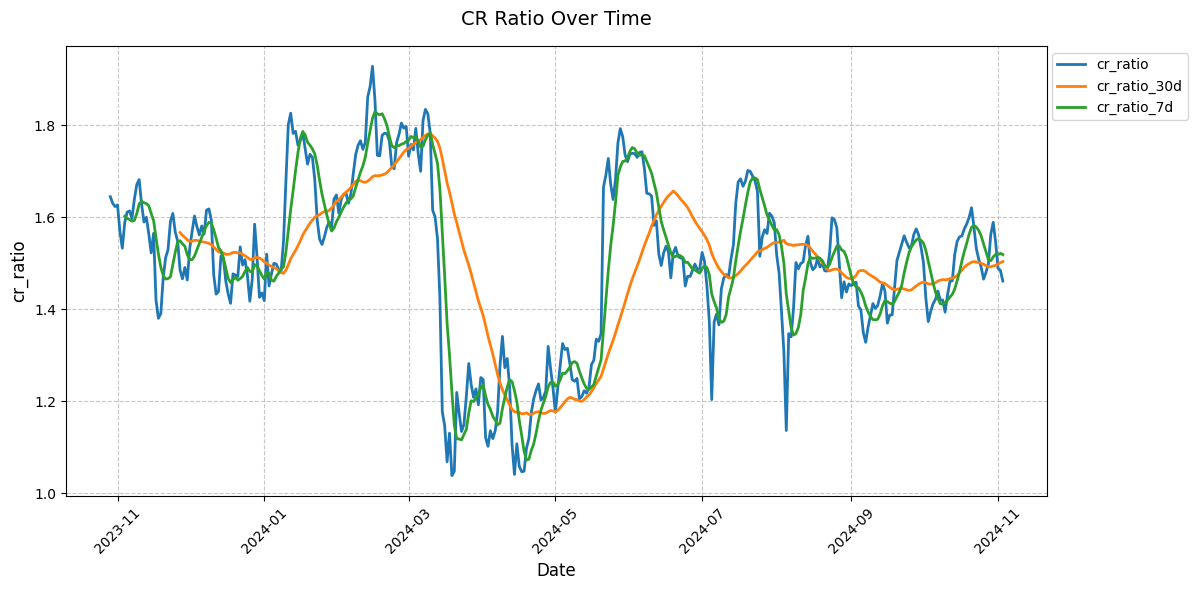

In [96]:
# Plot total debt and collateral amount over time
metrics_to_plot = ['cr_ratio', 'cr_ratio_30d', 'cr_ratio_7d']
plot_market_metrics(snapshots_df, metrics_to_plot, "CR Ratio Over Time")


In [37]:
def fetch_liquidation_overview(market_address: str, chain: str = "ethereum") -> Dict:
    """
    Fetch liquidation overview data for a specific crvUSD market
    
    Parameters:
    -----------
    market_address : str
        The market address to fetch data for
    chain : str
        The blockchain network (default: "ethereum")
        
    Returns:
    --------
    Dict containing liquidation metrics including:
        - soft_liquidation_users
        - median_health
        - average_health
        - collat_ratio
        - bad_debt
        - liquidatable_positions
        - liquidatable metrics (debt, stablecoin, collateral) in both raw and USD terms
    """
    # Ensure we're using checksum address
    w3 = Web3()
    market_address = w3.to_checksum_address(market_address)
    
    url = f"https://prices.curve.fi/v1/crvusd/liquidations/{chain}/{market_address}/overview"
    params = {
        "fetch_on_chain": "false"
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()
    
    return response.json()



In [38]:
# Example usage:
market_address = "0x4e59541306910ad6dc1dac0ac9dfb29bd9f15c67"
liquidation_data = fetch_liquidation_overview(market_address)

In [39]:
liquidation_data

{'soft_liquidation_users': 8,
 'median_health': 83.47467718732736,
 'average_health': 95.73329831599692,
 'collat_ratio': 191.6313244390151,
 'bad_debt': 0.0,
 'liquidatable_positions': 0,
 'liquidatable_pos_debt': '0.00 crvUSD',
 'liquidatable_stablecoin': '0.00 crvUSD',
 'liquidatable_collateral': '0.00 WBTC',
 'liquidatable_pos_debt_usd': 0.0,
 'liquidatable_collateral_usd': 0.0,
 'liquidatable_stablecoin_usd': 0.0}

In [40]:
def fetch_liquidation_losses(market_address: str, chain: str = "ethereum") -> pd.DataFrame:
    """
    Fetch historical liquidation losses data for a specific crvUSD market
    
    Parameters:
    -----------
    market_address : str
        The market address to fetch data for
    chain : str
        The blockchain network (default: "ethereum")
        
    Returns:
    --------
    pd.DataFrame containing liquidation loss metrics including:
        - timestamp
        - median_pct_loss
        - avg_pct_loss
        - median_abs_loss
        - avg_abs_loss
        - total_users
        - users_with_losses
        - ratio
    """
    # Ensure we're using checksum address
    w3 = Web3()
    market_address = w3.to_checksum_address(market_address)
    
    url = f"https://prices.curve.fi/v1/crvusd/liquidations/{chain}/{market_address}/losses/history"
    params = {
        "fetch_on_chain": "false"
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()
    
    # Convert to DataFrame
    df = pd.DataFrame(response.json()['data'])
    
    # Process DataFrame
    if not df.empty:
        # Convert timestamp to datetime
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        
        # Sort by date ascending
        df.sort_index(inplace=True)
    
    return df


In [41]:
market_address = "0x4e59541306910ad6dc1dac0ac9dfb29bd9f15c67"
losses_df = fetch_liquidation_losses(market_address)

losses_df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 91 entries, 2024-08-03 to 2024-11-01
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   median_pct_loss    91 non-null     float64
 1   avg_pct_loss       91 non-null     float64
 2   median_abs_loss    91 non-null     float64
 3   avg_abs_loss       91 non-null     float64
 4   total_users        91 non-null     int64  
 5   users_with_losses  91 non-null     int64  
 6   ratio              91 non-null     float64
dtypes: float64(5), int64(2)
memory usage: 5.7 KB


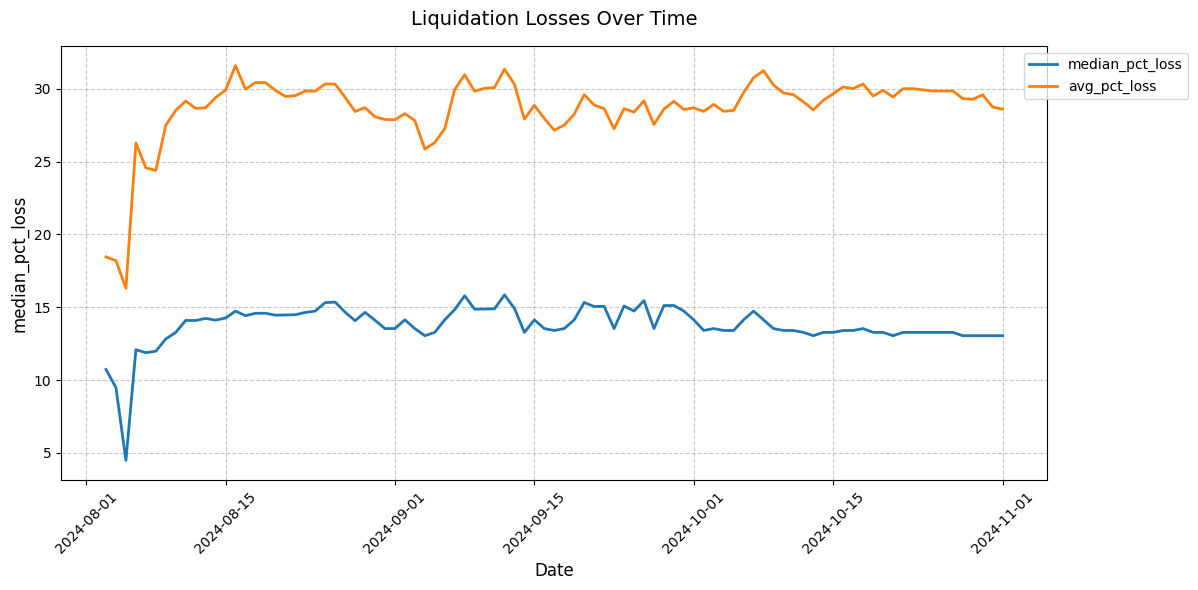

In [42]:
# Plot total debt and collateral amount over time
metrics_to_plot = ['median_pct_loss', 'avg_pct_loss']
plot_market_metrics(losses_df, metrics_to_plot, "Liquidation Losses Over Time")

In [44]:
def fetch_all_users(market_address: str, chain: str = "ethereum") -> pd.DataFrame:
    """
    Fetch all user data for a specific crvUSD market and store it in a DataFrame.
    
    Parameters:
    -----------
    market_address : str
        The market address to fetch user data for
    chain : str
        The blockchain network (default: "ethereum")
        
    Returns:
    --------
    pd.DataFrame containing user data including:
        - user address
        - first interaction timestamp
        - last interaction timestamp
    """
    page = 1
    per_page = 100
    all_users = []

    while True:
        url = f"https://prices.curve.fi/v1/crvusd/users/{chain}/{market_address}/users"
        params = {
            "page": page,
            "per_page": per_page
        }
        
        response = requests.get(url, params=params)
        response.raise_for_status()
        
        data = response.json()
        all_users.extend(data['data'])
        
        # Check if we have retrieved all data
        if page * per_page >= data['count']:
            break
        
        page += 1

    # Convert to DataFrame
    df = pd.DataFrame(all_users)
    
    # Convert timestamps to datetime
    df['first'] = pd.to_datetime(df['first'])
    df['last'] = pd.to_datetime(df['last'])
    
    return df


In [45]:
market_address = "0x4e59541306910ad6dc1dac0ac9dfb29bd9f15c67"
users_df = fetch_all_users(market_address)

print(users_df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   user    300 non-null    object        
 1   first   300 non-null    datetime64[ns]
 2   last    300 non-null    datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 7.2+ KB
None


In [51]:
def filter_users_by_max_last_date(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filter the DataFrame to extract users based on the maximum last active date (ignoring time).
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing user data with a 'last' column for last active date.
        
    Returns:
    --------
    pd.DataFrame
        Filtered DataFrame with users having the maximum last active date.
    """
    # Ensure 'last' column is in datetime format
    df['last'] = pd.to_datetime(df['last'])
    
    # Extract the date part from 'last' column
    df['last_date'] = df['last'].dt.date
    
    # Find the maximum date
    max_date = df['last_date'].max()
    
    # Filter the DataFrame to include only rows with the maximum date
    filtered_df = df[df['last_date'] == max_date]
    
    # Drop the 'last_date' column if not needed
    filtered_df = filtered_df.drop(columns=['last_date'])
    
    return filtered_df

In [52]:
# Assuming 'users_df' is  DataFrame with user data
filtered_users_df = filter_users_by_max_last_date(users_df)

# Print the first few rows of the filtered DataFrame
print(filtered_users_df.head())

                                         user               first  \
0  0x595b736e58F50Fc15373732C1fAB56d6E043Aef6 2024-09-06 19:30:23   
1  0x9E44418C03649A4db98980c0F674942828E2C813 2023-12-26 10:39:35   
2  0xfc1293798360553182ae58bCecdDD336E918dE4e 2023-08-04 23:45:47   
3  0x13dc93FC5C681d5D119782203F3CcCE7e16bAd16 2024-03-05 23:17:11   
4  0x891a534e7FbF12D34e74E9fFfA8f6FE28158D0D3 2024-02-27 10:09:47   

                 last  
0 2024-11-01 21:08:47  
1 2024-11-01 20:00:11  
2 2024-11-01 20:00:11  
3 2024-11-01 20:00:11  
4 2024-11-01 20:00:11  


In [53]:
filtered_users_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202 entries, 0 to 201
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   user    202 non-null    object        
 1   first   202 non-null    datetime64[ns]
 2   last    202 non-null    datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 6.3+ KB


In [58]:
def fetch_users_stats(user_addresses: List[str], market_address: str, chain: str = "ethereum") -> Dict[str, Dict]:
    """
    Fetch stats for multiple users from a specific crvUSD market
    
    Parameters:
    -----------
    user_addresses : List[str]
        List of user addresses to fetch stats for
    market_address : str
        The market address to fetch stats from
    chain : str
        The blockchain network (default: "ethereum")
        
    Returns:
    --------
    Dict[str, Dict]
        Dictionary mapping user addresses to their stats
    """
    # Initialize Web3 for checksum addresses
    w3 = Web3()
    market_address = w3.to_checksum_address(market_address)
    
    # Initialize results dictionary
    users_stats = {}
    
    for user_address in user_addresses:
        # Convert to checksum address
        user_address = w3.to_checksum_address(user_address)
        
        # Construct URL
        url = f"https://prices.curve.fi/v1/crvusd/users/{chain}/{user_address}/{market_address}/stats"
        
        try:
            response = requests.get(url)
            response.raise_for_status()
            
            # Store the stats in the dictionary with user address as key
            users_stats[user_address] = response.json()
            
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for user {user_address}: {str(e)}")
            users_stats[user_address] = None
            
    return users_stats

def create_users_stats_df(filtered_users_df: pd.DataFrame, market_address: str) -> pd.DataFrame:
    """
    Create a DataFrame with complete stats for all users from the filtered DataFrame
    
    Parameters:
    -----------
    filtered_users_df : pd.DataFrame
        DataFrame containing filtered user addresses
    market_address : str
        The market address to fetch stats from
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing all user stats
    """
    # Get list of user addresses from filtered DataFrame
    user_addresses = filtered_users_df['user'].tolist()
    
    # Fetch stats for all users
    users_stats = fetch_users_stats(user_addresses, market_address)
    
    # Create list to store processed data
    processed_data = []
    
    # Process each user's stats
    for user, stats in users_stats.items():
        if stats is not None:
            data = {
                'user': user,
                'health': stats.get('health'),
                'health_full': stats.get('health_full'),
                'n1': stats.get('n1'),
                'n2': stats.get('n2'),
                'n': stats.get('n'),
                'debt': stats.get('debt'),
                'collateral': stats.get('collateral'),
                'stablecoin': stats.get('stablecoin'),
                'soft_liquidation': stats.get('soft_liquidation'),
                'total_deposited': stats.get('total_deposited'),
                'loss': stats.get('loss'),
                'loss_pct': stats.get('loss_pct'),
                'collateral_up': stats.get('collateral_up'),
                'oracle_price': stats.get('oracle_price'),
                'block_number': stats.get('block_number'),
                'timestamp': pd.to_datetime(stats.get('timestamp'))
            }
            processed_data.append(data)
    
    # Create DataFrame from processed data
    stats_df = pd.DataFrame(processed_data)
    
    return stats_df


In [59]:
# Assuming filtered_users_df is your filtered DataFrame with user addresses
market_address = "0x4e59541306910ad6dc1dac0ac9dfb29bd9f15c67"
users_stats_df = create_users_stats_df(filtered_users_df, market_address)

# Display basic information about the new DataFrame
print("\nDataFrame Info:")
print(users_stats_df.info())

# Display first few rows
print("\nFirst few rows:")
print(users_stats_df.head())

Error fetching data for user 0xb587526953Ad321C1aB2eA26F7311d2aA1A98a4a: 500 Server Error: Internal Server Error for url: https://prices.curve.fi/v1/crvusd/users/ethereum/0xb587526953Ad321C1aB2eA26F7311d2aA1A98a4a/0x4e59541306910aD6dC1daC0AC9dFB29bD9F15c67/stats

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   user              201 non-null    object        
 1   health            201 non-null    float64       
 2   health_full       201 non-null    float64       
 3   n1                201 non-null    int64         
 4   n2                201 non-null    int64         
 5   n                 201 non-null    int64         
 6   debt              201 non-null    float64       
 7   collateral        201 non-null    float64       
 8   stablecoin        201 non-null    float64       
 9   soft_liquidation

In [60]:
users_stats_df

,user,health,health_full,n1,n2,n,debt,collateral,stablecoin,soft_liquidation,total_deposited,loss,loss_pct,collateral_up,oracle_price,block_number,timestamp
0,0x595b736e58F50Fc15373732C1fAB56d6E043Aef6,4.339096,7.906014,-65,-62,4,69597.275845,1.174577,0.000000,False,1.237344,0.062767,5.072755,1.174577,69215.016799,21095904,2024-11-01 22:52:52.455596
1,0x9E44418C03649A4db98980c0F674942828E2C813,3.745485,89.538981,-13,-4,10,17588.418378,0.512801,0.000000,False,0.512801,0.000000,0.000000,0.512801,69215.016799,21095904,2024-11-01 22:52:53.082651
2,0xfc1293798360553182ae58bCecdDD336E918dE4e,4.202069,141.510718,11,14,4,50350.311291,1.821570,0.000000,False,1.821570,0.000000,0.000000,1.821570,69215.016799,21095904,2024-11-01 22:52:53.781388
3,0x13dc93FC5C681d5D119782203F3CcCE7e16bAd16,3.667697,282.736913,56,59,4,10690.695232,0.604829,0.000000,False,0.709353,0.104523,14.735026,0.604829,69215.016799,21095904,2024-11-01 22:52:54.330117
4,0x891a534e7FbF12D34e74E9fFfA8f6FE28158D0D3,3.419987,50.667755,-34,-25,10,66052.057248,1.554471,0.000000,False,1.554471,0.000000,0.000000,1.554471,69215.016799,21095904,2024-11-01 22:52:54.660832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0x7449023394Bb2eB814fF6793963453Ce50A30b5E,3.410818,86.923497,-14,-5,10,17287.321036,0.497372,0.000000,False,0.497372,0.000000,0.000000,0.497372,69217.627881,21095911,2024-11-01 22:54:23.113081
197,0x8B65c201b2b3EC9a45187513C92F34176a91EFeF,4.207082,261.707346,50,53,4,25920.127647,1.387806,0.000000,False,1.387806,0.000000,0.000000,1.387806,69217.627881,21095911,2024-11-01 22:54:23.482598
198,0x3cfa5D941DA8F15CF005c8aF7AF1759E0b1CCD6e,3.304001,50.504856,-34,-25,10,20711.953615,0.486889,0.000000,False,0.486889,0.000000,0.000000,0.486889,69217.627881,21095911,2024-11-01 22:54:23.992650
199,0x3D09AaF464624a7ee4E1dad2639120a31E0a46cC,3.718697,64.729709,-25,-22,4,102207.753750,2.563156,0.000000,False,2.615817,0.052661,2.013194,2.563156,69217.627881,21095911,2024-11-01 22:54:24.360340


In [61]:
def fetch_ohlc_data(
    pool_address: str, 
    main_token: str, 
    reference_token: str, 
    start_time: int, 
    end_time: int,
    chain: str = "ethereum",
    agg_number: int = 1,
    agg_units: str = "day"
) -> pd.DataFrame:
    """
    Fetch OHLC data for a specific pool and token pair
    
    Parameters:
    -----------
    pool_address : str
        The pool address
    main_token : str
        Address of the main token
    reference_token : str
        Address of the reference token
    start_time : int
        Start timestamp
    end_time : int
        End timestamp
    chain : str
        The blockchain network (default: "ethereum")
    agg_number : int
        Number of units for aggregation (default: 1)
    agg_units : str
        Unit for aggregation - 'day', 'hour', etc. (default: "day")
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing OHLC data with datetime index
    """
    # Initialize Web3 for checksum addresses
    w3 = Web3()
    pool_address = w3.to_checksum_address(pool_address)
    main_token = w3.to_checksum_address(main_token)
    reference_token = w3.to_checksum_address(reference_token)
    
    # Construct URL
    url = f"https://prices.curve.fi/v1/ohlc/{chain}/{pool_address}"
    
    params = {
        "main_token": main_token,
        "reference_token": reference_token,
        "agg_number": agg_number,
        "agg_units": agg_units,
        "start": start_time,
        "end": end_time
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        
        # Convert to DataFrame
        df = pd.DataFrame(data['data'])
        
        # Convert timestamp to datetime and set as index
        df['time'] = pd.to_datetime(df['time'], unit='s')
        df = df.set_index('time')
        
        return df
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching OHLC data: {str(e)}")
        return None


---

In [17]:
import os
import pandas as pd
import numpy as np
from scipy import stats

def get_ohlc(gc_id) -> pd.DataFrame:
    
    # Gives the last 180 days of OHLC data
    
    url = f"https://api.coingecko.com/api/v3/coins/{gc_id}/ohlc?vs_currency=usd&days=365"

    headers = {
        "accept": "application/json",
        "x-cg-demo-api-key": os.getenv("GECKO_API_KEY")
    }

    response = requests.get(url, headers=headers)
    response.raise_for_status()
    
    # Convert to DataFrame
    df = pd.DataFrame(response.json(), columns=['timestamp', 'open', 'high', 'low', 'close'])
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    
    # Sort by timestamp ascending
    df.sort_index(inplace=True)
    
    return df


def analyze_price_drops(gc_id, drop_thresholds=[0.075, 0.15]) -> dict:
    """
    Calculate probability of price drops using Garman-Klass volatility estimator
    
    Args:
        gc_id: CoinGecko ID for the asset
        drop_thresholds: List of drop thresholds as decimals (e.g., 0.075 for 7.5% drop)
        
    Returns:
        dict: Probabilities for each threshold
    """
    ohlc_df = get_ohlc(gc_id)
    
    # Calculate daily returns using all OHLC data
    daily_returns = (ohlc_df['close'] - ohlc_df['open']) / ohlc_df['open']
    
    # Calculate true range based returns for better volatility estimation
    true_range_pct = (ohlc_df['high'] - ohlc_df['low']) / ohlc_df['open']
    
    # Combine both metrics for a more complete picture
    all_returns = pd.concat([daily_returns, true_range_pct])
    
    # Remove outliers beyond 5 standard deviations
    returns_mean = all_returns.mean()
    returns_std = all_returns.std()
    clean_returns = all_returns[np.abs(all_returns - returns_mean) <= (5 * returns_std)]
    
    # Fit a t-distribution (better for crypto's fat tails)
    params = stats.t.fit(clean_returns)
    df, loc, scale = params
    
    probabilities = {}
    for index, threshold in enumerate(drop_thresholds):
        # Calculate probability of a drop greater than the threshold
        prob_parametric = stats.t.cdf(-threshold, df, loc, scale)
        
        # Calculate historical probability
        prob_historical = len(daily_returns[daily_returns <= -threshold]) / len(daily_returns)
        
        probabilities[f"drop{index+1}"] = {
            'parametric_probability': float(prob_parametric),
            'historical_probability': float(prob_historical),
            'threshold_pct': float(threshold * 100)
        }
    
    return probabilities

In [18]:
import json

probabilities = analyze_price_drops("bitcoin",[0.075, 0.15])
        
print(json.dumps(probabilities, indent=4))

prob_drop1 = probabilities[f"drop1"]['parametric_probability']
prob_drop2 = probabilities[f"drop2"]['parametric_probability']

{
    "drop1": {
        "parametric_probability": 0.016374779335258337,
        "historical_probability": 0.021739130434782608,
        "threshold_pct": 7.5
    },
    "drop2": {
        "parametric_probability": 0.00024860145663321837,
        "historical_probability": 0.0,
        "threshold_pct": 15.0
    }
}


---

In [73]:
# Example usage:
pool_address = "0x4ebdf703948ddcea3b11f675b4d1fba9d2414a14"
main_token = "0xf939e0a03fb07f59a73314e73794be0e57ac1b4e"  # crvUSD
reference_token = "0xd533a949740bb3306d119cc777fa900ba034cd52"  # CRV
start_time = 1714761488
end_time = 1730662688

ohlc_df_crv = fetch_ohlc_data(
    pool_address=pool_address,
    main_token=main_token,
    reference_token=reference_token,
    start_time=start_time,
    end_time=end_time
)


In [74]:
# Example usage:
pool_address = "0x7f86bf177dd4f3494b841a37e810a34dd56c829b"
main_token = "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48"  # USDC
reference_token = "0x2260fac5e5542a773aa44fbcfedf7c193bc2c599"  # WBTC
start_time = 1714761488
end_time = 1730662688

ohlc_df_btc = fetch_ohlc_data(
    pool_address=pool_address,
    main_token=main_token,
    reference_token=reference_token,
    start_time=start_time,
    end_time=end_time
)

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import norm

def analyze_price_drops(ohlc_df, drop_thresholds=[0.075, 0.15]):
    """
    Analyze probability of specific price drops based on historical OHLC data with Laplace distribution
    """
    # Calculate different types of returns
    daily_returns = (ohlc_df['close'] - ohlc_df['open']) / ohlc_df['open']
    
    # Calculate volatilities (unchanged)
    high_low_volatility = np.sqrt(
        (1 / (4 * np.log(2))) * 
        ((np.log(ohlc_df['high'] / ohlc_df['low'])) ** 2)
    ).mean()
    
    log_hl = (np.log(ohlc_df['high'] / ohlc_df['low'])) ** 2
    log_co = (np.log(ohlc_df['close'] / ohlc_df['open'])) ** 2
    
    garman_klass_volatility = np.sqrt(
        (0.5 * log_hl) - 
        (2 * np.log(2) - 1) * log_co
    ).mean()
    
    close_volatility = daily_returns.std()
    
    # Fit Laplace distribution instead of Normal
    loc, scale = stats.laplace.fit(daily_returns)
    
    probabilities = {}
    for threshold in drop_thresholds:
        # Use Laplace CDF instead of Normal
        prob_parametric = stats.laplace.cdf(-threshold, loc, scale)
        prob_historical = len(daily_returns[daily_returns <= -threshold]) / len(daily_returns)
        
        probabilities[f"{threshold*100}%_drop"] = {
            'parametric_probability': prob_parametric,
            'historical_probability': prob_historical
        }
    
    # Create visualization data for Laplace distribution
    x = np.linspace(daily_returns.min(), daily_returns.max(), 100)
    pdf = stats.laplace.pdf(x, loc, scale)

    stats_dict = {
        'mean_return': loc,  # location parameter of Laplace
        'scale': scale,      # scale parameter of Laplace
        'close_to_close_volatility': close_volatility,
        'parkinson_volatility': high_low_volatility,
        'garman_klass_volatility': garman_klass_volatility,
        'skewness': stats.skew(daily_returns),
        'kurtosis': stats.kurtosis(daily_returns),
        'normality_test': stats.normaltest(daily_returns)
    }
    
    # Create visualization with Laplace fit
    plt.figure(figsize=(10, 6))
    plt.hist(daily_returns, bins=30, density=True, alpha=0.7, color='blue', label='Historical Returns')
    plt.plot(x, pdf, 'r-', lw=2, label='Laplace Distribution Fit')
    for threshold in drop_thresholds:
        plt.axvline(-threshold, color='red', linestyle='--', alpha=0.5, 
                   label=f'{threshold*100}% Drop Threshold')
    plt.title('Distribution of Daily Returns with Laplace Fit')
    plt.xlabel('Daily Return')
    plt.ylabel('Density')
    plt.legend()
        
    return {
        'probabilities': probabilities,
        'statistics': stats_dict,
        'visualization_data': {
            'x': x,
            'pdf': pdf,
            'returns': daily_returns
        }
    }


Probability of 7.5%_drop:
Parametric estimate: 7.40%
Historical estimate: 5.95%

Probability of 15.0%_drop:
Parametric estimate: 0.99%
Historical estimate: 1.08%

Volatility Measures:
Close-to-Close Volatility: 5.19%
Parkinson Volatility: 4.07%
Garman-Klass Volatility: 4.02%

Other Statistics:
Mean Return: -0.38%
Skewness: 0.46
Kurtosis: 3.85

Normality Test:
Statistic: 29.22
p-value: 0.0000


e:\Projects\llamaRiskDataNotebooks\env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


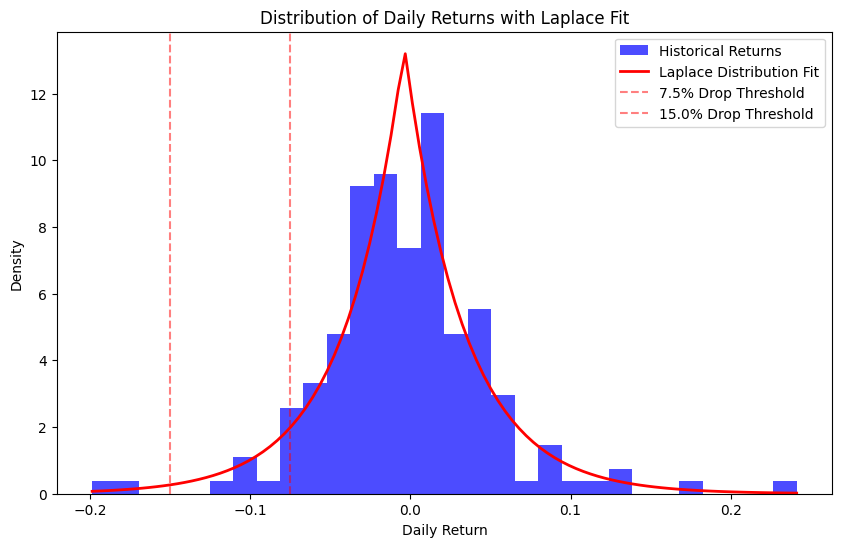

In [79]:
results = analyze_price_drops(ohlc_df_crv)

# Print probability results
for drop, probs in results['probabilities'].items():
    print(f"\nProbability of {drop}:")
    print(f"Parametric estimate: {probs['parametric_probability']:.2%}")
    print(f"Historical estimate: {probs['historical_probability']:.2%}")

# Print volatility statistics
print("\nVolatility Measures:")
print(f"Close-to-Close Volatility: {results['statistics']['close_to_close_volatility']:.2%}")
print(f"Parkinson Volatility: {results['statistics']['parkinson_volatility']:.2%}")
print(f"Garman-Klass Volatility: {results['statistics']['garman_klass_volatility']:.2%}")

# Print other statistics
print("\nOther Statistics:")
print(f"Mean Return: {results['statistics']['mean_return']:.2%}")
print(f"Skewness: {results['statistics']['skewness']:.2f}")
print(f"Kurtosis: {results['statistics']['kurtosis']:.2f}")

# Print normality test results
normality_stat, normality_p = results['statistics']['normality_test']
print(f"\nNormality Test:")
print(f"Statistic: {normality_stat:.2f}")
print(f"p-value: {normality_p:.4f}")

In [75]:
import pandas as pd
import numpy as np
from scipy import stats

def calculate_gk_volatility(df, window=30):
    """
    Calculate Garman-Klass volatility for a given OHLC DataFrame
    
    Parameters:
    df: DataFrame with 'open', 'high', 'low', 'close' columns
    window: Rolling window size (default: 30 days)
    """
    log_hl = np.log(df['high'] / df['low'])
    log_co = np.log(df['close'] / df['open'])
    
    gk_vol = np.sqrt(
        (0.5 * log_hl.pow(2) -
         (2 * np.log(2) - 1) * log_co.pow(2)
        ).rolling(window=window).mean()
    )
    return gk_vol

def calculate_traditional_beta(asset_df, index_df, window=30):
    """
    Calculate traditional beta using close prices
    
    Parameters:
    asset_df: DataFrame with asset OHLC data
    index_df: DataFrame with index OHLC data
    window: Rolling window size (default: 30 days)
    
    Returns:
    tuple: (beta, r_squared)
    """
    # Calculate returns
    asset_returns = np.log(asset_df['close'] / asset_df['close'].shift(1))
    index_returns = np.log(index_df['close'] / index_df['close'].shift(1))
    
    # Calculate rolling beta
    cov = asset_returns.rolling(window=window).cov(index_returns)
    var = index_returns.rolling(window=window).var()
    beta = cov / var
    
    # Calculate R-squared
    rolling_corr = asset_returns.rolling(window=window).corr(index_returns)
    r_squared = rolling_corr ** 2
    
    return beta, r_squared

def calculate_gk_beta(asset_df, index_df, window=30):
    """
    Calculate beta using Garman-Klass volatility
    
    Parameters:
    asset_df: DataFrame with asset OHLC data
    index_df: DataFrame with index OHLC data
    window: Rolling window size (default: 30 days)
    
    Returns:
    tuple: (gk_beta, correlation)
    """
    # Calculate GK volatilities
    asset_gk_vol = calculate_gk_volatility(asset_df, window)
    index_gk_vol = calculate_gk_volatility(index_df, window)
    
    # Calculate returns for correlation
    asset_returns = np.log(asset_df['close'] / asset_df['close'].shift(1))
    index_returns = np.log(index_df['close'] / index_df['close'].shift(1))
    
    # Calculate rolling correlation
    rolling_corr = asset_returns.rolling(window=window).corr(index_returns)
    
    # Calculate GK beta
    gk_beta = rolling_corr * (asset_gk_vol / index_gk_vol)
    
    return gk_beta, rolling_corr

def analyze_beta(asset_df, index_df, window=30):
    """
    Perform comprehensive beta analysis using both traditional and GK methods
    
    Parameters:
    asset_df: DataFrame with asset OHLC data
    index_df: DataFrame with index OHLC data
    window: Rolling window size (default: 30 days)
    
    Returns:
    tuple: (analysis_df, summary_dict)
    """
    # Calculate both types of beta
    trad_beta, r_squared = calculate_traditional_beta(asset_df, index_df, window)
    gk_beta, correlation = calculate_gk_beta(asset_df, index_df, window)
    
    # Create analysis DataFrame
    analysis = pd.DataFrame({
        'traditional_beta': trad_beta,
        'gk_beta': gk_beta,
        'r_squared': r_squared,
        'correlation': correlation
    })
    
    # Calculate summary statistics
    summary = {
        'traditional_beta': {
            'mean': trad_beta.mean(),
            'std': trad_beta.std(),
            'median': trad_beta.median(),
            'current': trad_beta.iloc[-1]
        },
        'gk_beta': {
            'mean': gk_beta.mean(),
            'std': gk_beta.std(),
            'median': gk_beta.median(),
            'current': gk_beta.iloc[-1]
        },
        'r_squared': {
            'mean': r_squared.mean(),
            'median': r_squared.median(),
            'current': r_squared.iloc[-1]
        }
    }
    
    return analysis, summary

def print_beta_summary(summary):
    """
    Print a formatted summary of beta analysis
    
    Parameters:
    summary: Dictionary containing beta analysis summary statistics
    """
    print("\nBeta Analysis Summary:")
    print("-" * 50)
    
    print("\nTraditional Beta:")
    print(f"Current: {summary['traditional_beta']['current']:.3f}")
    print(f"Mean: {summary['traditional_beta']['mean']:.3f}")
    print(f"Std Dev: {summary['traditional_beta']['std']:.3f}")
    
    print("\nGarman-Klass Beta:")
    print(f"Current: {summary['gk_beta']['current']:.3f}")
    print(f"Mean: {summary['gk_beta']['mean']:.3f}")
    print(f"Std Dev: {summary['gk_beta']['std']:.3f}")
    
    print("\nModel Fit:")
    print(f"R-squared (current): {summary['r_squared']['current']:.3f}")
    print(f"R-squared (mean): {summary['r_squared']['mean']:.3f}")


    

In [76]:
# Run analysis
analysis, summary = analyze_beta(ohlc_df_crv, ohlc_df_btc, window=30)

# Print summary
print_beta_summary(summary)

# Print recent values
print("\nRecent Analysis:")
print(analysis.tail())


Beta Analysis Summary:
--------------------------------------------------

Traditional Beta:
Current: 0.941
Mean: 1.095
Std Dev: 0.411

Garman-Klass Beta:
Current: 0.714
Mean: 1.155
Std Dev: 1.043

Model Fit:
R-squared (current): 0.412
R-squared (mean): 0.283

Recent Analysis:
                     traditional_beta   gk_beta  r_squared  correlation
time                                                                   
2024-10-30 18:38:08          1.015914  1.033013   0.520670     0.721575
2024-10-31 18:38:08          0.921183  0.907429   0.436078     0.660362
2024-11-01 18:38:08          0.948913  0.862016   0.410228     0.640490
2024-11-02 18:38:08          0.946028  0.709357   0.411810     0.641724
2024-11-03 18:38:08          0.940753  0.713686   0.411778     0.641700


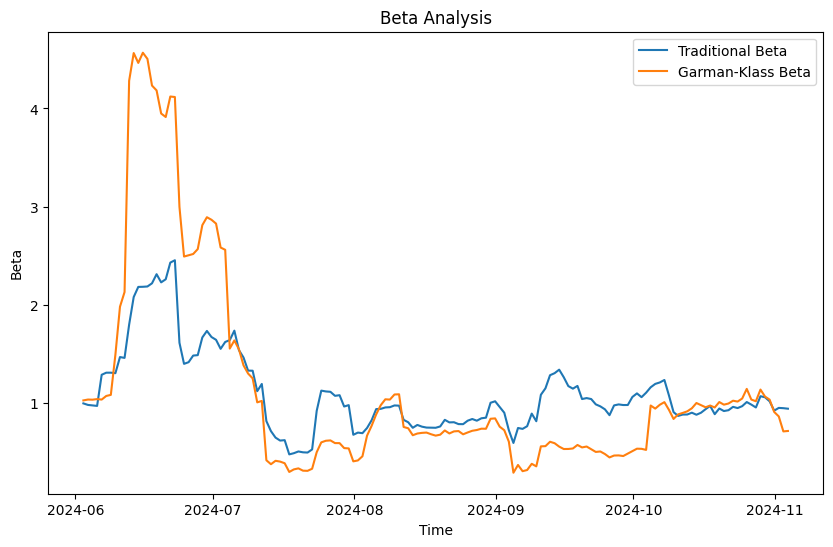

In [77]:
# Plot the beta analysis
plt.figure(figsize=(10, 6))
plt.plot(analysis['traditional_beta'], label='Traditional Beta')
plt.plot(analysis['gk_beta'], label='Garman-Klass Beta')
plt.title('Beta Analysis')
plt.xlabel('Time')
plt.ylabel('Beta')
plt.legend()
plt.show()

In [86]:
def calculate_recent_gk_volatility(ohlc_df: pd.DataFrame) -> dict:
    """
    Calculate Garman-Klass volatility for the last 60 and 15 days
    
    Parameters:
    -----------
    ohlc_df : pd.DataFrame
        DataFrame with OHLC data and datetime index
        
    Returns:
    --------
    dict
        Dictionary containing GK volatility for 60-day and 15-day periods
    """
    # Ensure the DataFrame is sorted by date
    ohlc_df = ohlc_df.sort_index()
    
    # Function to calculate GK volatility
    def gk_volatility(df):
        log_hl = (np.log(df['high'] / df['low'])) ** 2
        log_co = (np.log(df['close'] / df['open'])) ** 2
        
        return np.sqrt(
            (0.5 * log_hl) - 
            (2 * np.log(2) - 1) * log_co
        ).mean()
    
    # Get the last 60 and 15 days of data
    last_60_days = ohlc_df.last('60D')
    last_15_days = ohlc_df.last('15D')
    
    # Calculate volatilities
    volatility_60d = gk_volatility(last_60_days)
    volatility_15d = gk_volatility(last_15_days)
    
    return {
        'gk_volatility_60d': volatility_60d,
        'gk_volatility_15d': volatility_15d,
        'volatility_ratio': volatility_15d / volatility_60d if volatility_60d != 0 else None
    }

In [87]:
# Example usage:
volatilities = calculate_recent_gk_volatility(ohlc_df_crv)
print(f"60-day GK Volatility: {volatilities['gk_volatility_60d']:.2%}")
print(f"15-day GK Volatility: {volatilities['gk_volatility_15d']:.2%}")
print(f"15d/60d Volatility Ratio: {volatilities['volatility_ratio']:.2f}")

60-day GK Volatility: 2.53%
15-day GK Volatility: 2.06%
15d/60d Volatility Ratio: 0.82


C:\Users\dhruv\AppData\Local\Temp\ipykernel_828\1903597102.py:29: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_60_days = ohlc_df.last('60D')
C:\Users\dhruv\AppData\Local\Temp\ipykernel_828\1903597102.py:30: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_15_days = ohlc_df.last('15D')


In [88]:
# Example usage:
volatilities = calculate_recent_gk_volatility(ohlc_df_btc)
print(f"60-day GK Volatility: {volatilities['gk_volatility_60d']:.2%}")
print(f"15-day GK Volatility: {volatilities['gk_volatility_15d']:.2%}")
print(f"15d/60d Volatility Ratio: {volatilities['volatility_ratio']:.2f}")

60-day GK Volatility: 1.81%
15-day GK Volatility: 2.15%
15d/60d Volatility Ratio: 1.19


C:\Users\dhruv\AppData\Local\Temp\ipykernel_828\1903597102.py:29: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_60_days = ohlc_df.last('60D')
C:\Users\dhruv\AppData\Local\Temp\ipykernel_828\1903597102.py:30: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_15_days = ohlc_df.last('15D')


In [89]:
def calculate_recent_gk_beta(asset_df: pd.DataFrame, 
                             index_df: pd.DataFrame, 
                             days: int = 30) -> float:
    """
    Calculate a single Garman-Klass beta value using the most recent days of data
    
    Parameters:
    -----------
    asset_df : pd.DataFrame
        DataFrame with asset OHLC data
    index_df : pd.DataFrame
        DataFrame with index OHLC data
    days : int
        Number of recent days to consider (default: 30)
        
    Returns:
    --------
    float
        Single GK beta value for the period
    """
    # Get the last n days of data
    asset_recent = asset_df.last(f'{days}D')
    index_recent = index_df.last(f'{days}D')
    
    # Calculate GK volatility for the period
    def gk_volatility(df):
        log_hl = np.log(df['high'] / df['low'])
        log_co = np.log(df['close'] / df['open'])
        
        return np.sqrt(
            (0.5 * log_hl.pow(2) -
             (2 * np.log(2) - 1) * log_co.pow(2)
            ).mean()
        )
    
    # Calculate returns for correlation
    asset_returns = np.log(asset_recent['close'] / asset_recent['close'].shift(1))
    index_returns = np.log(index_recent['close'] / index_recent['close'].shift(1))
    
    # Calculate correlation
    correlation = asset_returns.corr(index_returns)
    
    # Calculate volatilities
    asset_gk_vol = gk_volatility(asset_recent)
    index_gk_vol = gk_volatility(index_recent)
    
    # Calculate GK beta
    gk_beta = correlation * (asset_gk_vol / index_gk_vol)
    
    return gk_beta


In [91]:

# Example usage:
beta = calculate_recent_gk_beta(ohlc_df_crv, ohlc_df_btc)
print(f"30-day GK Beta: {beta:.3f}")

30-day GK Beta: 0.712


C:\Users\dhruv\AppData\Local\Temp\ipykernel_828\876855123.py:20: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  asset_recent = asset_df.last(f'{days}D')
C:\Users\dhruv\AppData\Local\Temp\ipykernel_828\876855123.py:21: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  index_recent = index_df.last(f'{days}D')


In [16]:
def score_bad_debt(bad_debt: float,
                   current_debt: float,
                   method: str = 'quadratic_balanced') -> float:
    """
    Score bad debt ratio with different quadratic interpolation methods
    
    Args:
        bad_debt (float): Amount of bad debt
        current_debt (float): Total current debt
        method (str): Interpolation method:
            - quadratic_balanced: Moderate curve (default)
            - quadratic_conservative: Steeper penalty
            - quadratic_aggressive: More lenient curve
            - quadratic_custom: Customizable steepness
        
    Returns:
        float: Score between 0 and 1
    """
    # Constants
    IGNORE_THRESHOLD = 0.001  # 0.1% of current debt
    CRITICAL_THRESHOLD = 0.01  # 1% of current debt
    
    # Convert to ratio for easier calculation
    bad_debt_ratio = bad_debt / current_debt if current_debt > 0 else 0
    
    # If below ignore threshold, return perfect score
    if bad_debt_ratio <= IGNORE_THRESHOLD:
        return 1.0
    
    # If above critical threshold, return zero
    if bad_debt_ratio >= CRITICAL_THRESHOLD:
        return 0.0
    
    # Normalize the ratio to [0,1] range for interpolation
    x = (bad_debt_ratio - IGNORE_THRESHOLD) / (CRITICAL_THRESHOLD - IGNORE_THRESHOLD)
    
    if method == 'quadratic_balanced':
        # Balanced quadratic curve
        return 1 - x * x*x
        
    else:
        # Default to balanced quadratic
        return 1 - x * x

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_quadratic_methods(current_debt: float = 1000000):
    """
    Visualize different quadratic scoring methods for bad debt
    """
    # Create range of bad debt values to test
    bad_debt_values = np.linspace(0, current_debt * 0.02, 200)
    
    # Calculate scores for each method
    balanced_scores = [score_bad_debt(bd, current_debt, 'quadratic_balanced') 
                      for bd in bad_debt_values]
    
    # Convert bad debt values to percentages
    x_axis = [bd/current_debt * 100 for bd in bad_debt_values]
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    plt.plot(x_axis, balanced_scores, label='Balanced', linewidth=2)
    
    # Add threshold lines
    plt.axvline(x=0.1, color='gray', linestyle='--', alpha=0.5, 
                label='Ignore Threshold (0.1%)')
    plt.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, 
                label='Critical Threshold (1.0%)')
    
    # Customize the plot
    plt.title('Quadratic Bad Debt Scoring Methods Comparison', fontsize=14, pad=20)
    plt.xlabel('Bad Debt Ratio (%)', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set axis limits
    plt.xlim(0, 2)
    plt.ylim(-0.1, 1.1)
    
    plt.tight_layout()
    plt.show()


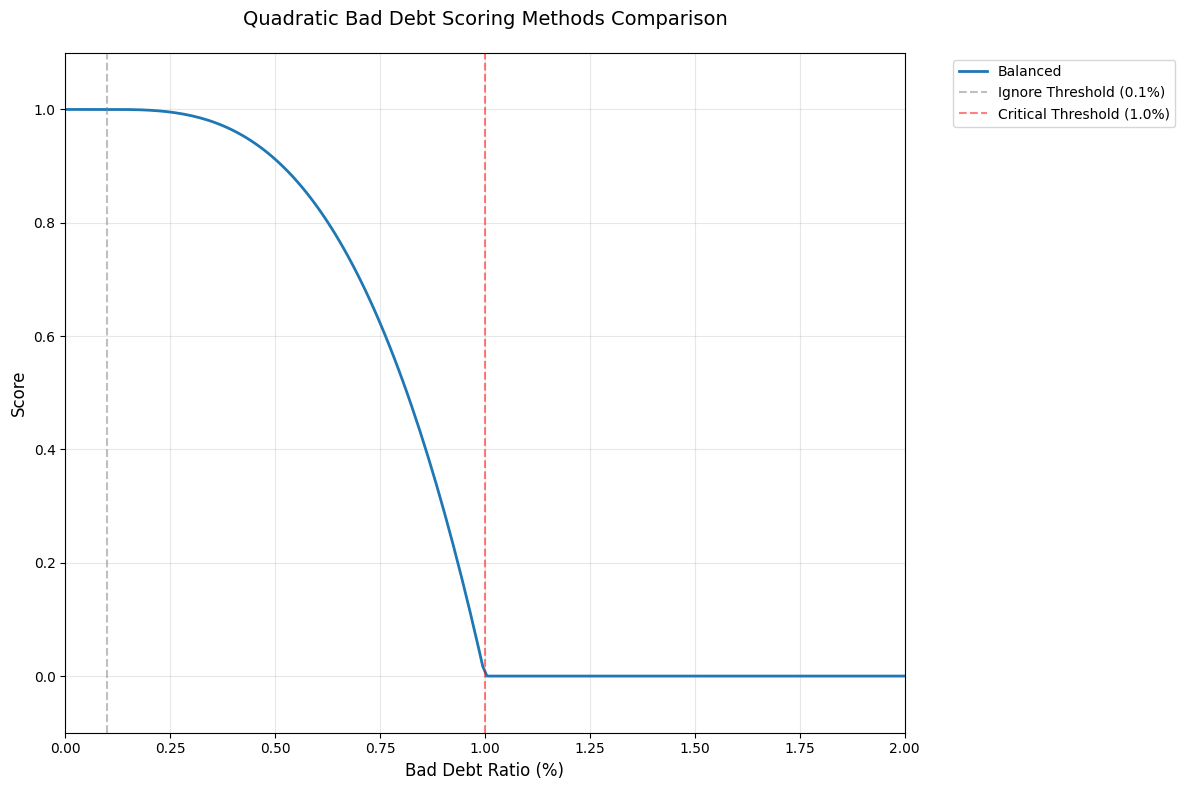

In [19]:

# Example usage with 1 million current debt
plot_quadratic_methods(1000000)